# Chest X-Ray Medical Diagnosis with Deep Learning

In [44]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces'

## Imports

In [45]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

In [46]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

In [12]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Paths Setup

In [13]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TEST_IMAGE_DIR)

datasets/images-small


In [14]:
IMAGE_DIR = Path(cfg.DATASET_DIRS.TRAIN_IMAGES_DIR )
TRAIN_CSV = Path(cfg.DATASET_DIRS.TRAIN_CSV)

IMAGE_SIZE = 320

## Load the Datasets
[ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.

### Loading the Data

In [15]:
train_df = pd.read_csv(f"{TRAIN_CSV}")

train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


### Total Labels

In [17]:
TRAIN_CSV_LABELS = ['Image Index', 'Finding Labels']

In [18]:
train_df_labels = train_df[TRAIN_CSV_LABELS[1]].str.get_dummies(sep='|').astype('float32')
train_df_labels.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
train_df_labels.columns, len(train_df_labels)

(Index(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
        'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
        'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
       dtype='object'),
 5606)

In [48]:
CLASSES_NAME = ['Atelectasis','Effusion','Infiltration', 'Mass', 'No Finding']
temp_df = train_df_labels.copy()
temp_df[CLASSES_NAME]

,Atelectasis,Effusion,Infiltration,Mass,No Finding
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,1.0
996,0.0,0.0,1.0,1.0,0.0
997,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0


In [21]:
labels = train_df_labels.columns

### Unique Check

In [22]:
train_df['Patient ID'].count(),train_df['Patient ID'].nunique()

(5606, 4230)

### Dataset Inbalance Check

In [23]:
sorted_df = train_df_labels.sum().sort_values()
sorted_df

Hernia                  13.0
Pneumonia               62.0
Fibrosis                84.0
Edema                  118.0
Emphysema              127.0
Cardiomegaly           141.0
Pleural_Thickening     176.0
Consolidation          226.0
Pneumothorax           271.0
Mass                   284.0
Nodule                 313.0
Atelectasis            508.0
Effusion               644.0
Infiltration           967.0
No Finding            3044.0
dtype: float32

In [24]:
sorted_df.values

array([  13.,   62.,   84.,  118.,  127.,  141.,  176.,  226.,  271.,
        284.,  313.,  508.,  644.,  967., 3044.], dtype=float32)

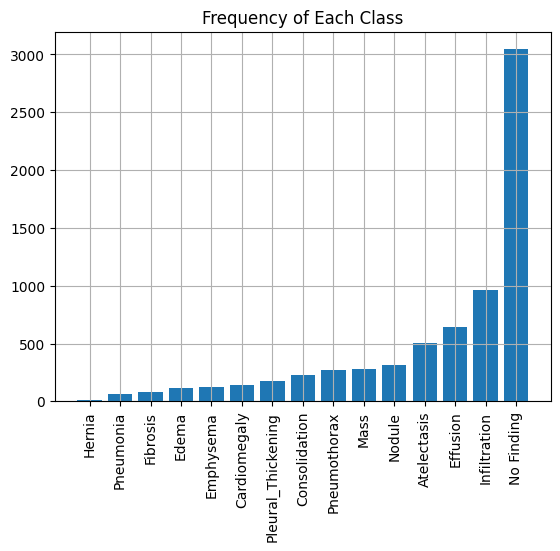

In [25]:
plt.xticks(rotation=90)
plt.bar(x=sorted_df.index, height=(sorted_df.values))
plt.title("Frequency of Each Class")
plt.grid()
plt.show()

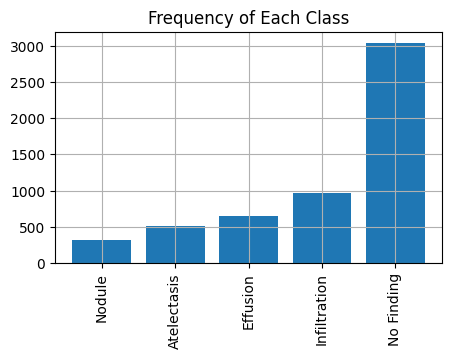

In [26]:
plt.figure(figsize=(5, 3))
train_labs = sorted_df[-5:]
plt.xticks(rotation=90)
plt.bar(x=train_labs.index, height=(train_labs.values))
plt.title("Frequency of Each Class")
plt.grid()
plt.show()

## Data Visualization

In [27]:
limit = 1000
train_df = train_df[:limit]
train_df_labels = train_df_labels[:limit]

In [28]:
len(train_df_labels)

1000

In [29]:
len(train_df_labels.values[10])

15

In [30]:
labels[np.argmax(train_df_labels.values[5])]

'Consolidation'

In [31]:
import random
IMAGE_NUM = 9
images = train_df['Image Index'].values
random_range = random.sample(range(0, len(images)), IMAGE_NUM)
random_range

[805, 53, 927, 268, 561, 217, 17, 71, 260]

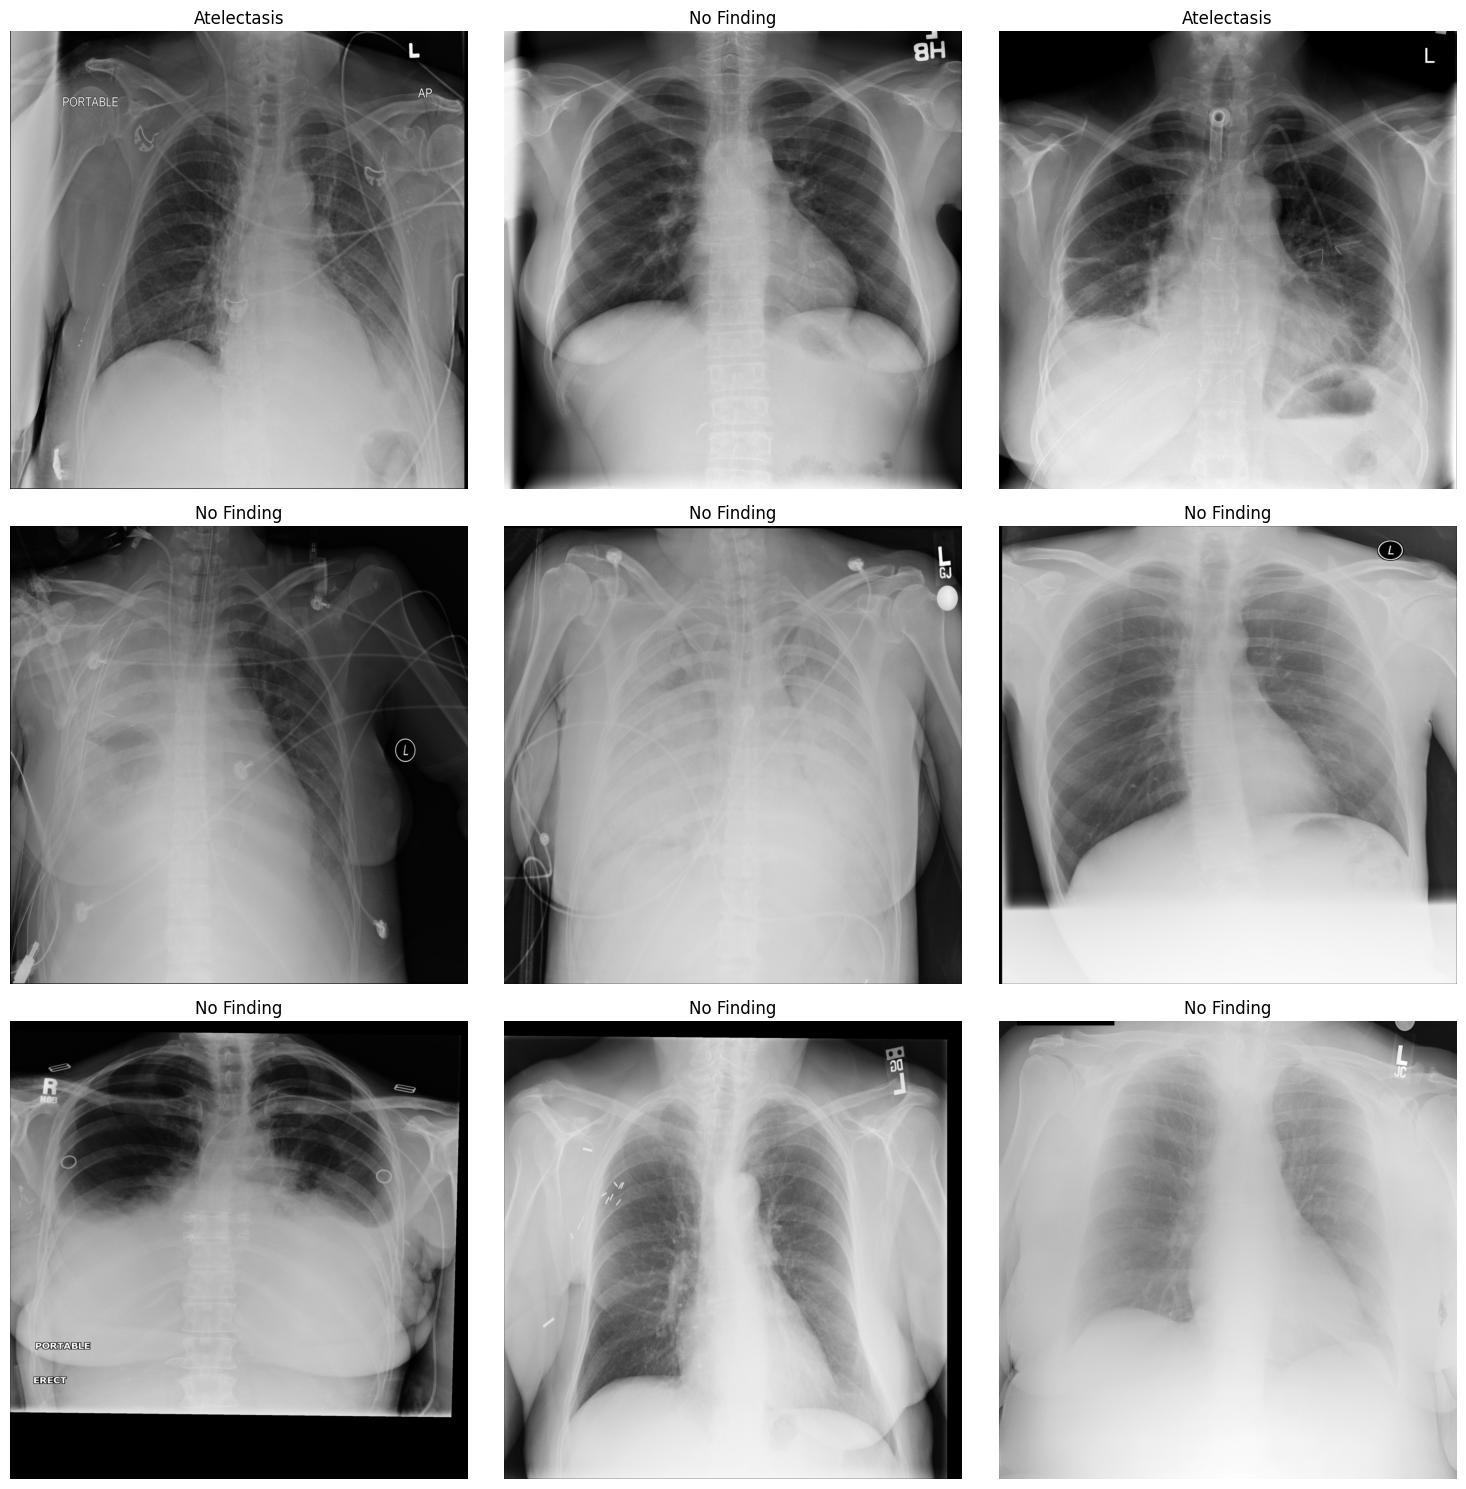

In [32]:

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_range):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(f"{IMAGE_DIR}/{images[idx]}")
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(labels[np.argmax(train_df_labels.values[idx])])
    
plt.tight_layout()
plt.show()

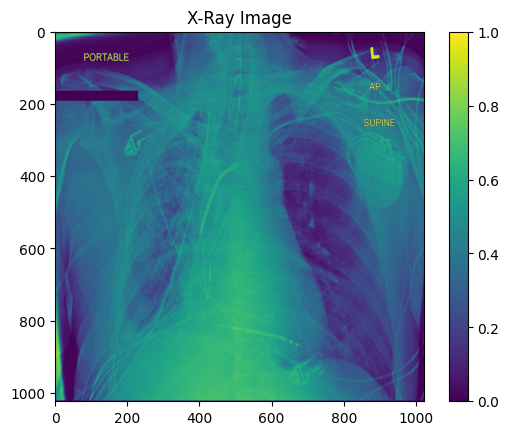

In [33]:
sample_image = train_df['Image Index'][0]
img = plt.imread(f"{IMAGE_DIR}/{sample_image}")
plt.imshow(img)
plt.title('X-Ray Image')
plt.colorbar()

In [34]:
img.min(),img.max(), img.mean(),img.std()

(0.0, 1.0, 0.36706418, 0.17620756)

## Augmentation visualization

In [35]:

def load_image(image_name, label):
    full_path = tf.strings.join([f'{IMAGE_DIR}/', image_name])
    image = tf.io.read_file(full_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image =tf.keras.preprocessing.image.smart_resize(image,[IMAGE_SIZE, IMAGE_SIZE])
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_df['Image Index'].values,  train_df_labels.values))
train_ds = train_ds.map(load_image)

I0000 00:00:1742722569.570128   98952 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6937 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [36]:
for batch in train_ds.take(1):
    image, label = batch
    print(image, label)

tf.Tensor(
[[[ 84.19       84.19       84.19     ]
  [ 84.7        84.7        84.7      ]
  [ 83.55       83.55       83.55     ]
  ...
  [  5.          5.          5.       ]
  [  5.          5.          5.       ]
  [  5.          5.          5.       ]]

 [[ 82.3        82.3        82.3      ]
  [ 82.1        82.1        82.1      ]
  [ 80.9        80.9        80.9      ]
  ...
  [  5.          5.          5.       ]
  [  5.          5.          5.       ]
  [  5.          5.          5.       ]]

 [[165.75      165.75      165.75     ]
  [161.15      161.15      161.15     ]
  [161.5       161.5       161.5      ]
  ...
  [  4.5         4.5         4.5      ]
  [  5.          5.          5.       ]
  [  5.          5.          5.       ]]

 ...

 [[122.25      122.25      122.25     ]
  [129.95      129.95      129.95     ]
  [143.75      143.75      143.75     ]
  ...
  [ 51.5        51.5        51.5      ]
  [ 14.799866   14.799866   14.799866 ]
  [  2.1499634   2.1499634   2.14

In [37]:
data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomRotation(0.10),
            tf.keras.layers.RandomTranslation(0.05, 0.05),
            tf.keras.layers.RandomZoom(0.1, 0.1)
])
aug_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y)) 

In [38]:
aug_dataset = list(aug_train_ds.as_numpy_iterator())

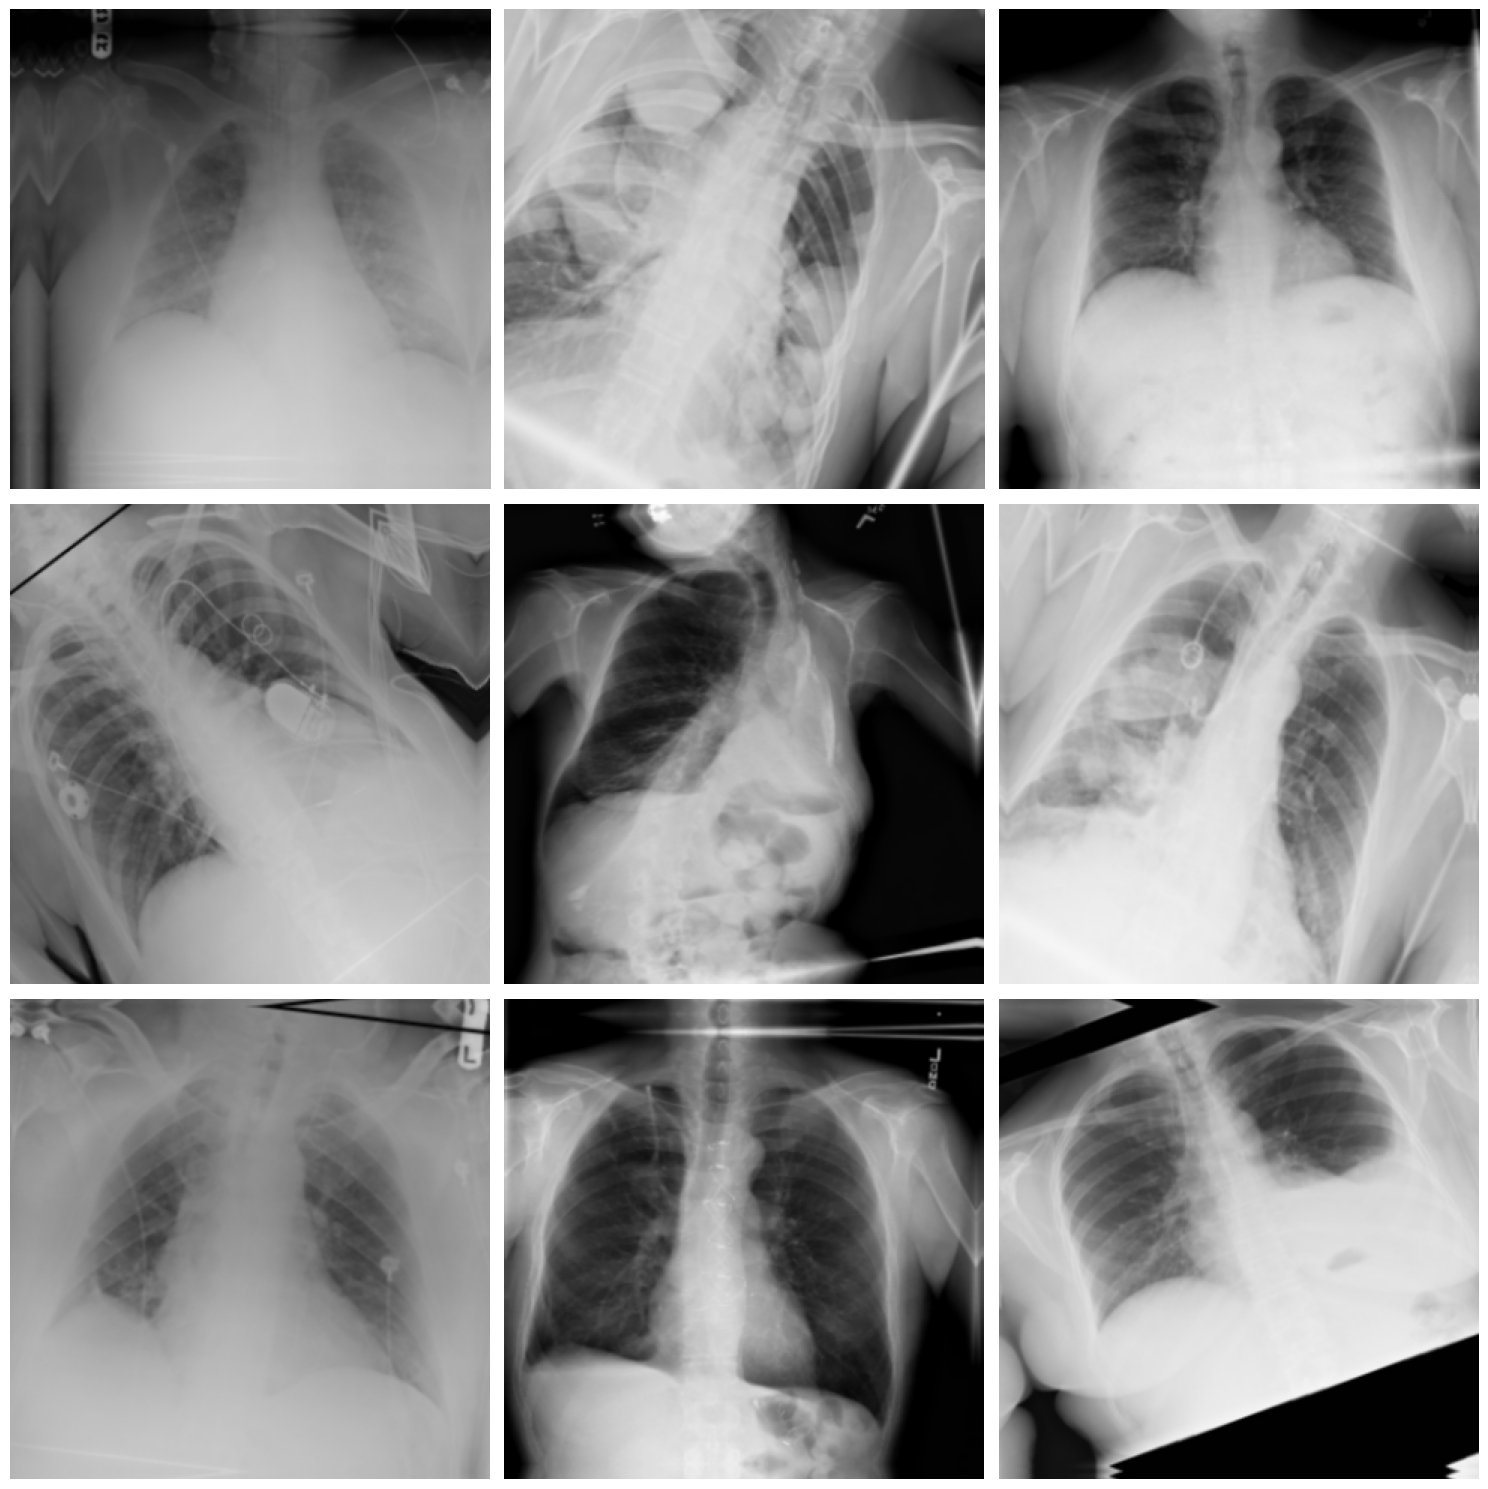

In [39]:
import random

IMAGE_NUM = 9

random_range = random.sample(range(0, len(aug_dataset)), IMAGE_NUM)

# random_images = [np.random.choice(images) for _ in range(IMAGE_NUM)]

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_range):
    plt.subplot(3, 3, i + 1)
    plt.imshow(aug_dataset[idx][0].astype('uint8'), cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

del aug_dataset

### Investigating Pixel Value Distribution

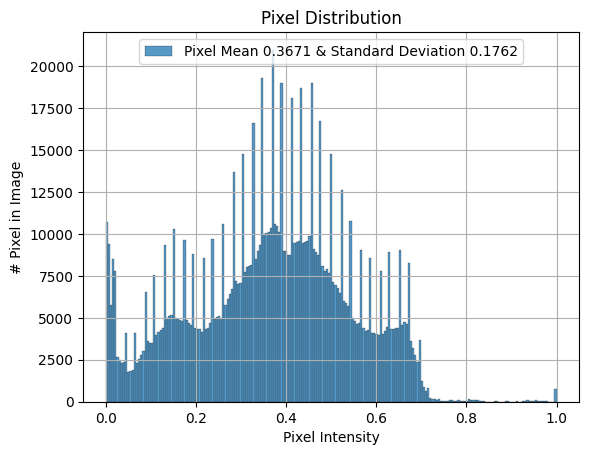

In [40]:
sns.histplot(img.ravel(),
    label=f'Pixel Mean {np.mean(img):.4f} & Standard Deviation {np.std(img):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Pixel Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel in Image')
plt.grid()

In [41]:
import keras
normalization_layer = keras.layers.Normalization()
images_for_stats =  tf.concat([images for images, _ in train_ds.take(int(len(train_df[:limit])*0.25))], axis=0) 
normalization_layer.adapt(images_for_stats)
del images_for_stats

In [42]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
norm_img = None
for batch in train_ds.take(1):
    image, label = batch
    norm_img = image.numpy()
    print(norm_img.min(), norm_img.max(), norm_img.mean(),norm_img.std())

-2.09914 1.8906567 -0.6329335 0.6992634


Generated Image: mean -0.6329 - Standard Deviation 0.6993 
Min pixel value -2.099 - Max pixel value 1.891


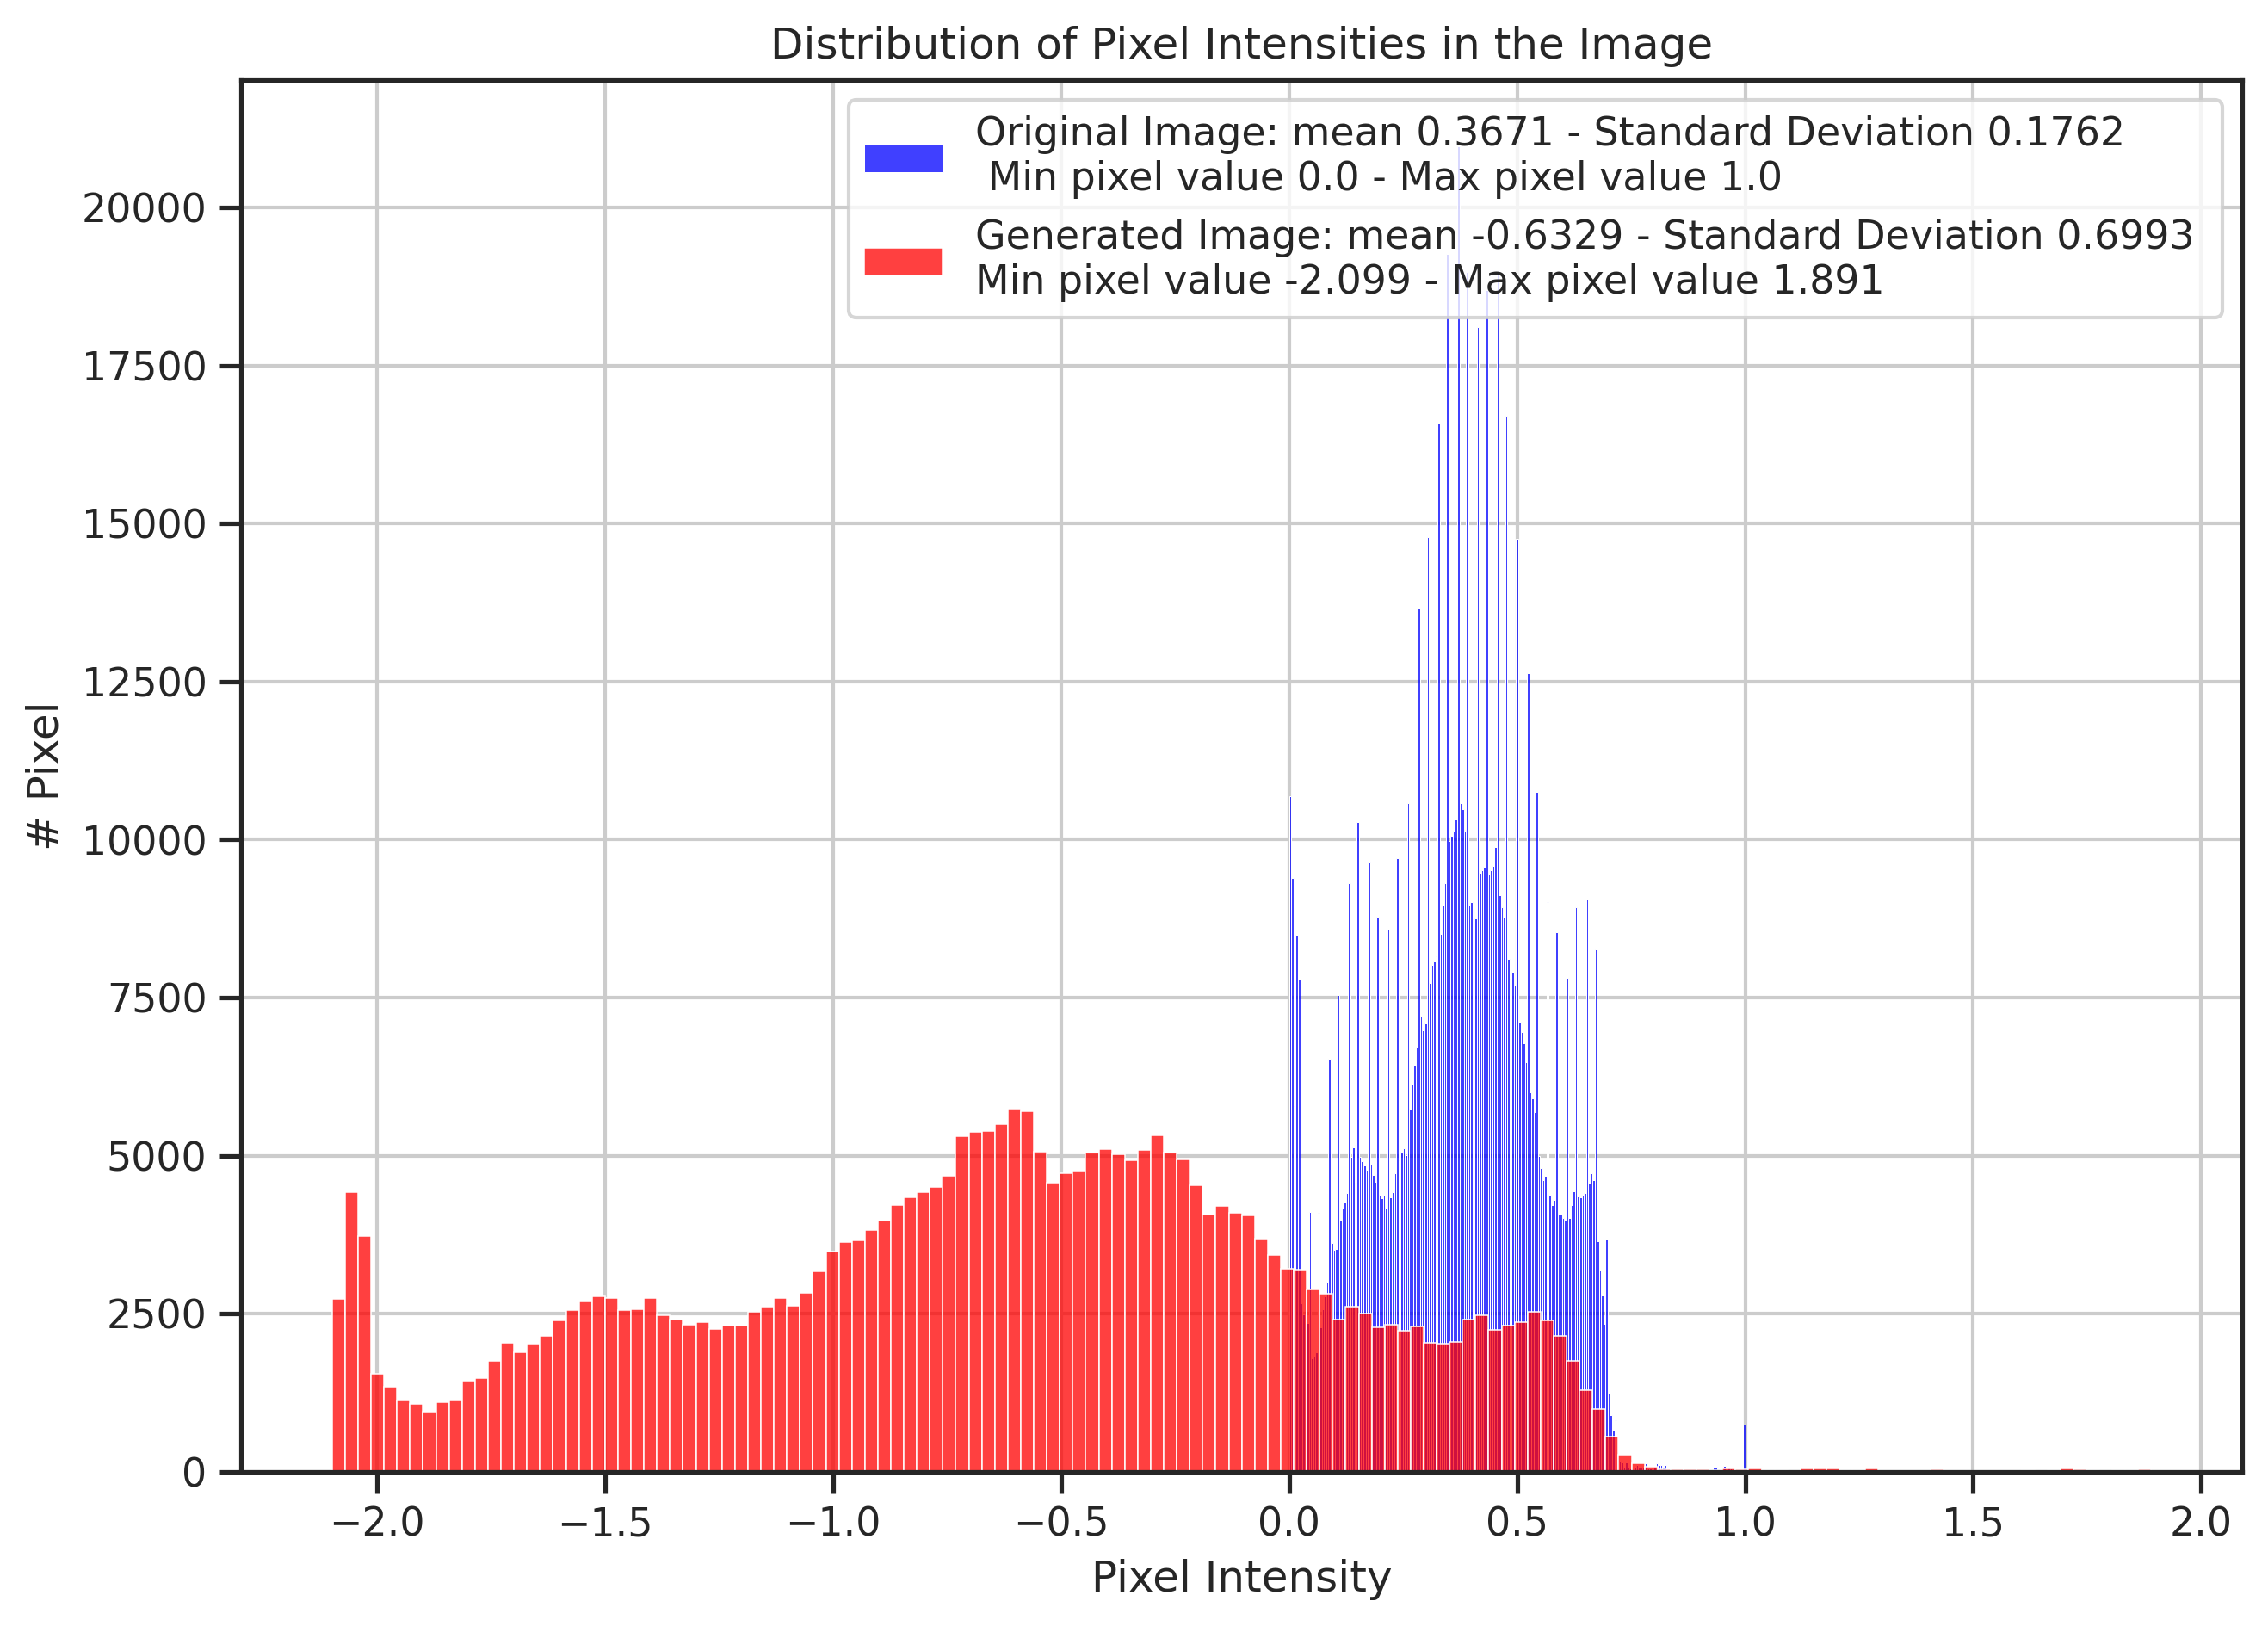

In [43]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
plt.figure(figsize=(10, 7))

sns.histplot(img.ravel(), 
             label=f'Original Image: mean {np.mean(img):.4f} - Standard Deviation {np.std(img):.4f} \n '
             f'Min pixel value {np.min(img):.4} - Max pixel value {np.max(img):.4}',
             color='blue', 
             kde=False)

# Plot histogram for generated image
sns.histplot(norm_img.ravel(), 
             label=f'Generated Image: mean {np.mean(norm_img):.4f} - Standard Deviation {np.std(norm_img):.4f} \n'
             f'Min pixel value {np.min(norm_img):.4} - Max pixel value {np.max(norm_img):.4}', 
             color='red', 
             kde=False)

plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.grid()
print(f'Generated Image: mean {np.mean(norm_img):.4f} - Standard Deviation {np.std(norm_img):.4f} \n'
             f'Min pixel value {np.min(norm_img):.4} - Max pixel value {np.max(norm_img):.4}')